# Download dataset with Pytorch



## Load the data

In [2]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image


# Define transformation for each image
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten()) #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)


Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


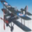

0

In [3]:
train_ds, val_ds, _= random_split(dataset, [20000,1000 ,29000])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Test Dataloader
for images, class_nums in train_loader:
  print(images.shape,class_nums.shape) # class_nums are tensor!
  pil_img = Image.fromarray(images[0].reshape(32,32,3).numpy())
  display(pil_img,
          class_nums[0].item()
          )
  break


# Implement LinearClassifier class for CIFAR10

In [65]:
class LinearClassifier:
  def __init__(self, labels, cross_entropy_loss = False, reg = 0.1):
    self.labels = labels
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    # You can change this code
    self.W = np.random.randn(3072 + 1, self.classes_num) * 0.0001
    self.batch_size = 200
    self.cross_entropy_loss = cross_entropy_loss
    self.reg = reg


  def train(self, x_batch, y_batch, learning_rate = 1e-8):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer
        representing a class number for objects from x

    """

    x_batch = self.add_bias(x_batch)
    loss, grad = self.loss(x_batch, y_batch)

    # Update weights (self.W)

    self.W -= learning_rate * grad

    return loss
  
  def add_bias(self, x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

  def loss(self,x, y): # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer
        representing a class number for objects from x

    """

    loss = 0.0
    dW = np.zeros(self.W.shape)

    # Calculate Multiclass SVM or Cross-entropy loss over a batch

    # Calculate gradients (dL/dW) and store it in dW

    # Hinge loss
    if not self.cross_entropy_loss:
      for i in range(x.shape[0]):
        scores = x[i].dot(self.W)
        score_i = scores[y[i]]

        n_positive_margin = 0
        for j in range(self.classes_num):
          if j == y[i]:
            continue
          
          margin = scores[j] - score_i + 1
          if margin > 0:
            loss += margin
            dW[:, j] += x[i]
            n_positive_margin += 1
        dW[:, y[i]] -= n_positive_margin * x[i]

      loss /= x.shape[0]
      dW /= x.shape[0]

    # Cross-entropy loss
    else:
      for i in range(x.shape[0]):
        scores = x[i].dot(self.W)
        escores = np.exp(scores)
        q = escores / np.sum(escores)
        loss += -scores[y[i]] + np.log(np.sum(escores))

        for j in range(self.classes_num):
          dW[:, j] += (q[j] - (j == y[i])) * x[i]

      loss /= x.shape[0]
      dW /= x.shape[0]

    # regularization
    loss += self.reg * np.sum(self.W * self.W)
    dW += 2 * self.reg * self.W

    return loss, dW

  def predict(self,x):
    # optionally you can add some preprocessing here
    x = self.add_bias(x)
    scores = x.dot(self.W)
    return np.argmax(scores,axis = 1)


# Train model

## Function for accuracy checking

Don't change this code

In [5]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index)
    y_gtrue = np.append(y_gtrue,class_nums.numpy())
  return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [68]:
from math import exp

model = LinearClassifier(dataset.classes, cross_entropy_loss=True, reg=0.01)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy(), learning_rate=1e-7)
  accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 2.1766933835324944, Accuracy:0.216
Epoch 1 Loss: 2.0839498734882174, Accuracy:0.256
Epoch 2 Loss: 2.0205519360405226, Accuracy:0.281
Epoch 3 Loss: 1.971771620924751, Accuracy:0.288
Epoch 4 Loss: 1.9321865574370938, Accuracy:0.294
Epoch 5 Loss: 1.8989649716212484, Accuracy:0.3
Epoch 6 Loss: 1.8703867171692519, Accuracy:0.31
Epoch 7 Loss: 1.8453281743807823, Accuracy:0.319
Epoch 8 Loss: 1.8230204586348902, Accuracy:0.324
Epoch 9 Loss: 1.8029177743520088, Accuracy:0.328
Epoch 10 Loss: 1.784620319256783, Accuracy:0.333
Epoch 11 Loss: 1.7678270816280812, Accuracy:0.342
Epoch 12 Loss: 1.7523059322882644, Accuracy:0.344
Epoch 13 Loss: 1.7378740970800801, Accuracy:0.347
Epoch 14 Loss: 1.7243850501079678, Accuracy:0.348
Epoch 15 Loss: 1.7117194873980988, Accuracy:0.349
Epoch 16 Loss: 1.699778959914225, Accuracy:0.349
Epoch 17 Loss: 1.6884812815115016, Accuracy:0.352
Epoch 18 Loss: 1.6777571485058393, Accuracy:0.356
Epoch 19 Loss: 1.6675476040848425, Accuracy:0.363
Epoch 20 Loss: 1

# Check model on test dataset

You must get accuracy above 0.35


In [69]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.3515


# Place for brief conclusion
Feel free to describe troubles here.


$lr=\cfrac{1\text{e-}6}{e^{\frac{epoch}{4}}}$


# Ideas for extra work

- Implenment CrossEntropyLoss function (done)
- Implement bias trick (done)
- Add regularization to SVM loss (done)
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


